<a href="https://colab.research.google.com/github/dude123studios/AdvancedDeepLearning/blob/main/Transformer_for_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 7.4MB/s 


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.datasets.cifar100 import load_data
import tensorflow_addons as tfa

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train) , (x_test, y_test) = load_data()

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
mlp_head_units = [2048, 1024]  

169009152/169001437 [==============================] - 3s 0us/step


In [4]:
data_augmentation = tf.keras.models.Sequential(
    [
        experimental.preprocessing.Normalization(),
        experimental.preprocessing.Resizing(image_size, image_size), 
        experimental.preprocessing.RandomFlip('horizontal'),
        experimental.preprocessing.RandomRotation(0.02),
        experimental.preprocessing.RandomZoom(0.2, 0.2)
    ],
    name='data_augmentation'
)
data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes= [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1, 1, 1, 1],
        padding='VALID'
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


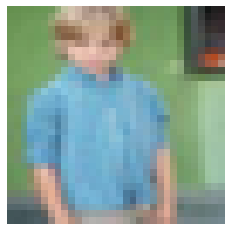

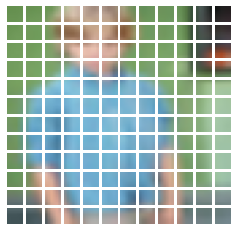

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [8]:
class PatchEncoder(Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = Dense(projection_dim)
    self.positional_encoding = Embedding(num_patches, projection_dim)

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.positional_encoding(positions)
    return encoded

In [9]:
def create_vit():
  inputs = Input(shape=input_shape)
  augmented = data_augmentation(inputs)
  patches = Patches(patch_size)(augmented)
  encoded_patches = PatchEncoder(num_patches,projection_dim)(patches)

  for _ in range(transformer_layers):
    
    x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention = MultiHeadAttention(num_heads, projection_dim, dropout=0.1)(x1, x1)

    x2 = Add()([encoded_patches, attention])

    x3 = LayerNormalization(epsilon=1e-6)(x2)

    x3 = mlp(x3, transformer_units, 0.1)

    encoded_patches = Add()([x2, x3])

  representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = Flatten()(representation)
  representation = Dropout(0.5)(representation)

  features = mlp(representation, mlp_head_units, 0.5)
  logits = Dense(num_classes)(features)
  
  model = tf.keras.Model(inputs=inputs, outputs=logits)
  return model

In [10]:
def train(model):
  optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,
                                   weight_decay=weight_decay)
  model.compile(optimizer=optimizer,
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = [
                    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                    tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy')
                  ]
                )
  checkpoint_filepath = '/tmp/checkpoint'
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor='val_accuracy',
      save_best_only=True,
      save_weights_only=True,
    )

  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[checkpoint_callback],
    )
  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

  return history


In [11]:
vit_classifier = create_vit()
history = train(vit_classifier)

Epoch 1/50
176/176 [==============================] - 78s 376ms/step - loss: 4.9119 - accuracy: 0.0300 - top-5-accuracy: 0.1118 - val_loss: 3.9339 - val_accuracy: 0.1032 - val_top-5-accuracy: 0.3032
Epoch 2/50
176/176 [==============================] - 65s 369ms/step - loss: 4.0006 - accuracy: 0.0868 - top-5-accuracy: 0.2712 - val_loss: 3.5408 - val_accuracy: 0.1550 - val_top-5-accuracy: 0.4060
Epoch 3/50
176/176 [==============================] - 65s 369ms/step - loss: 3.7020 - accuracy: 0.1289 - top-5-accuracy: 0.3613 - val_loss: 3.3514 - val_accuracy: 0.2030 - val_top-5-accuracy: 0.4746
Epoch 4/50
176/176 [==============================] - 65s 370ms/step - loss: 3.4904 - accuracy: 0.1617 - top-5-accuracy: 0.4267 - val_loss: 3.1819 - val_accuracy: 0.2262 - val_top-5-accuracy: 0.5194
Epoch 5/50
176/176 [==============================] - 65s 369ms/step - loss: 3.3456 - accuracy: 0.1863 - top-5-accuracy: 0.4639 - val_loss: 3.0567 - val_accuracy: 0.2544 - val_top-5-accuracy: 0.5534
Epoch